In [1]:
import re
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
WORKING_DIR = os.path.join('.input', 'logistic')

In [3]:
quora = pd.read_csv('../data/.input/train.csv')

In [4]:
quora.head(10)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


In [5]:
quora_train, quora_test = train_test_split(quora, random_state=42)
quora_train_data = quora_train.question_text
quora_train_labels = quora_train.target * 2.0 - 1.0
quora_test_data = quora_test.question_text
quora_test_labels = quora_test.target * 2.0 - 1.0

In [6]:
def to_vw_format(document, label=None):
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'

In [7]:
!!mkdir $WORKING_DIR
trainDataPath = os.path.join(WORKING_DIR, 'train.mw')
testDataPath = os.path.join(WORKING_DIR, 'test.mw')
modelPath = os.path.join(WORKING_DIR, 'model.mw')
predictionsPath = os.path.join(WORKING_DIR, 'test_predictions.txt')
cachePath = os.path.join(WORKING_DIR, 'cache')

In [10]:
with open(trainDataPath, 'w', encoding='utf-8') as vw_train_data:
    for text, target in zip(quora_train_data, quora_train_labels):
        vw_train_data.write(to_vw_format(text, target))
with open(testDataPath, 'w', encoding='utf-8') as vw_test_data:
    for text, target in zip(quora_test_data, quora_test_labels):
        vw_test_data.write(to_vw_format(text, target))

In [8]:
!!vw -d $trainDataPath  --passes 4 --cache_file $cachePath --loss_function logistic  -f $modelPath

['final_regressor = .input\\logistic\\model.mw',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'decay_learning_rate = 1',
 'using cache_file = .input\\logistic\\cache',
 'ignoring text input in favor of cache input',
 'num sources = 1',
 'average  since         example        example  current  current  current',
 'loss     last          counter         weight    label  predict features',
 '0.693147 0.693147            1            1.0  -1.0000   0.0000       15',
 '0.652329 0.611511            2            2.0  -1.0000  -0.1705        6',
 '0.573442 0.494555            4            4.0  -1.0000  -0.6636        8',
 '0.466002 0.358561            8            8.0  -1.0000  -1.0173       16',
 '0.456395 0.446788           16           16.0  -1.0000  -0.7221        5',
 '0.349735 0.243076           32           32.0  -1.0000  -2.4341        8',
 '0.301908 0.254081           64           64.0  -1.0000  -1.5463        3',
 '0.302351 0.302794          1

In [9]:
!!vw -i $modelPath -t -d $testDataPath -p $predictionsPath

['only testing',
 'predictions = .input\\logistic\\test_predictions.txt',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'using no cache',
 'Reading datafile = .input\\logistic\\test.mw',
 'num sources = 1',
 'average  since         example        example  current  current  current',
 'loss     last          counter         weight    label  predict features',
 '56.913933 56.913933            1            1.0  -1.0000  -8.5441       13',
 '35.143147 13.372362            2            2.0  -1.0000  -4.6568        9',
 '44.505529 53.867911            4            4.0  -1.0000 -10.3877       11',
 '37.683351 30.861172            8            8.0  -1.0000  -5.7752       11',
 '27.998498 18.313645           16           16.0  -1.0000  -5.0617        8',
 '24.846759 21.695019           32           32.0  -1.0000  -3.8562        8',
 '20.931045 17.015332           64           64.0  -1.0000  -6.6764       11',
 '19.677226 18.423406          128          12

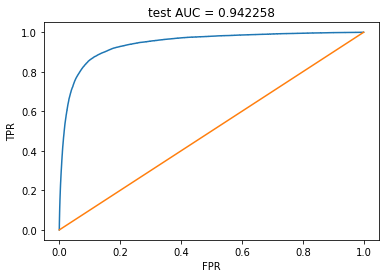

In [11]:
with open(predictionsPath) as pred_file:
    quora_test_prediction = [float(label) 
                             for label in pred_file.readlines()]

auc = roc_auc_score(quora_test_labels, quora_test_prediction)
curve = roc_curve(quora_test_labels, quora_test_prediction)


plt.plot(curve[0], curve[1]);
plt.plot([0,1], [0,1])
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);


In [12]:
quora_test_pred = list(map(lambda x: -1.0 if x < 0.0 else 1.0, quora_test_prediction))
print('accuracy', accuracy_score(quora_test_labels, quora_test_pred))
print('precision', precision_score(quora_test_labels, quora_test_pred))
print('recall', recall_score(quora_test_labels, quora_test_pred))
print('f1', f1_score(quora_test_labels, quora_test_pred))
confusion_matrix(quora_test_labels, quora_test_pred)

accuracy 0.9539706796598179
precision 0.7006457941633287
recall 0.4298610762826621
f1 0.5328235732935472


array([[302930,   3662],
       [ 11368,   8571]], dtype=int64)